In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import defaultdict
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import wandb

from models.unet import UNet
from utils.datasets import OrigaDataset, load_origa
from utils.metrics import *

In [2]:
IMAGE_DIR = '../data/ORIGA/Images_Cropped'
MASK_DIR = '../data/ORIGA/Masks_Cropped'
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
BATCH_SIZE = 4
LEARNING_RATE = 1e-4
EPOCHS = 5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LOAD_MODEL = False
PIN_MEMORY = True if DEVICE == 'cuda' else False
USE_WANDB = False

print(f'PyTorch version: {torch.__version__}')
print(f'Using device: {DEVICE}')

PyTorch version: 2.0.1+cu118
Using device: cuda


In [3]:
config = {
    'image_size': (IMAGE_HEIGHT, IMAGE_WIDTH),
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'epochs': EPOCHS,
}

# Initialize Weights & Biases
if USE_WANDB:
    wandb.init(project='DP-Glaucoma')
    wandb.config.update(config)

Image shape: torch.Size([1, 3, 128, 128])
Mask shape: torch.Size([1, 128, 128])
Unique values and their counts in mask: {0: 5922, 1: 5486, 2: 4976}


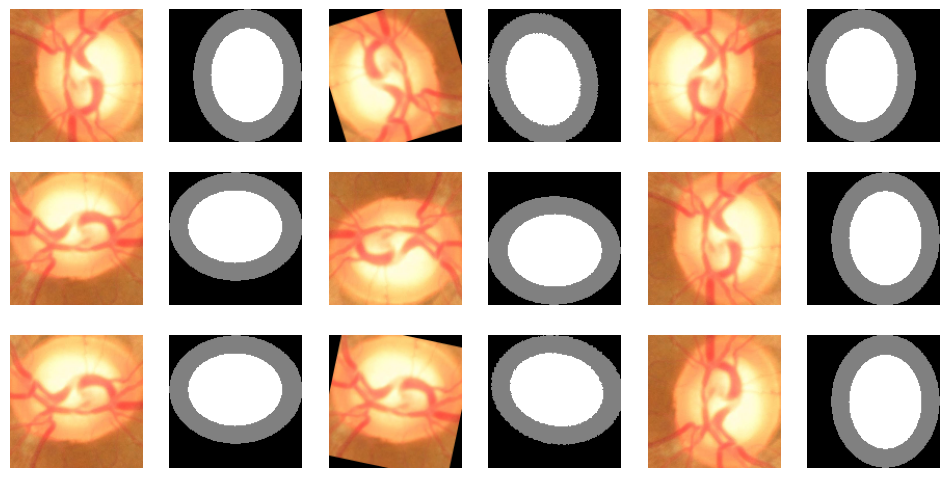

In [4]:
example_ds = OrigaDataset(IMAGE_DIR, MASK_DIR, os.listdir(IMAGE_DIR)[:1], A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1.0),  # rotate by 0, 90, 180, or 270 degrees
    A.Rotate(limit=30, p=0.33, border_mode=cv.BORDER_CONSTANT),
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
    ToTensorV2(),
]))
example_loader = DataLoader(example_ds, batch_size=1, shuffle=True)

example_image, example_mask = next(iter(example_loader))
print(f'Image shape: {example_image.shape}')
print(f'Mask shape: {example_mask.shape}')

unique, counts = np.unique(example_mask, return_counts=True)
print(f'Unique values and their counts in mask: {dict(zip(unique, counts))}')

# Plot example augmented images and masks
fig, ax = plt.subplots(3, 6, figsize=(12, 6))
ax = ax.ravel()
for i in range(0, 3 * 6, 2):
    image, mask = next(iter(example_loader))
    image = image.squeeze().permute(1, 2, 0).numpy()
    mask = mask.squeeze().numpy()
    ax[i].imshow(image)
    ax[i].axis('off')
    ax[i + 1].imshow(mask, cmap='gray')
    ax[i + 1].axis('off')
plt.show()

In [5]:
train_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1.0),
    A.Rotate(limit=30, p=0.25, border_mode=cv.BORDER_CONSTANT),
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
    ToTensorV2()
])

train_ds, val_ds, test_ds = load_origa(
    IMAGE_DIR, MASK_DIR, train_transform, val_transform, val_transform,
    train_size=0.7, val_size=0.15, test_size=0.15,
    # train_size=0.01, val_size=0.01, test_size=0.98,
)

print(f'Train size: {len(train_ds)}')
print(f'Validation size: {len(val_ds)}')
print(f'Test size: {len(test_ds)}')

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

Train size: 454
Validation size: 98
Test size: 98


In [6]:
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    print('=> Saving checkpoint')
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print('=> Loading checkpoint')
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])


def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std


def train(model, criterion, optimizer, epochs, device, train_loader, val_loader=None, scheduler=None):
    history = defaultdict(list)
    train_length, val_length = len(train_loader), len(val_loader)

    if USE_WANDB:
        wandb.watch(model, criterion)

    model.to(device)

    for epoch in range(1, epochs + 1):
        print(f'Epoch {epoch}:')

        # training
        model.train()
        train_hist = defaultdict(list)
        train_loop = tqdm(train_loader, total=train_length, leave=True)
        train_loop.set_description(f'Training')
        for batch_idx, (images, masks) in enumerate(train_loop):
            images = images.to(device=device)
            masks = masks.to(device=device)

            # forward
            outputs = model(images)
            loss = criterion(outputs, masks.long())

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # metrics
            preds = torch.argmax(outputs, dim=1)
            epoch_metrics = get_performance_metrics(masks.cpu(), preds.cpu())
            for k, v in epoch_metrics.items():
                train_hist[k].append(v)
            train_hist['loss'].append(loss.item())

            # show summary after last batch
            if batch_idx == train_length - 1:
                # calculate mean metrics over all batches for the current training epoch
                for k, v in train_hist.items():
                    history[f'train_{k}'].append(np.mean(v))
                train_loop.set_postfix(
                    loss=history['train_loss'][-1],
                    acc=history['train_accuracy'][-1],
                    iou=history['train_iou'][-1],
                    dice=history['train_dice'][-1],
                )

        if scheduler is not None:
            scheduler.step(history['train_loss'][-1])

        if val_loader is None:
            continue

        # validation
        model.eval()
        val_hist = defaultdict(list)
        val_loop = tqdm(val_loader, total=val_length, leave=True)
        val_loop.set_description(f'Validation')
        with torch.no_grad():
            for batch_idx, (images, masks) in enumerate(val_loop):
                images = images.to(device=device)
                masks = masks.to(device=device)

                # forward
                outputs = model(images)
                loss = criterion(outputs, masks.long())

                # metrics
                preds = torch.argmax(outputs, dim=1)
                epoch_metrics = get_performance_metrics(masks.cpu(), preds.cpu())
                for k, v in epoch_metrics.items():
                    val_hist[k].append(v)
                val_hist['loss'].append(loss.item())

                # show summary after last batch
                if batch_idx == val_length - 1:
                    # calculate mean metrics over all batches for the current validation epoch
                    for k, v in val_hist.items():
                        history[f'val_{k}'].append(np.mean(v))
                    val_loop.set_postfix(
                        loss=history['val_loss'][-1],
                        acc=history['val_accuracy'][-1],
                        iou=history['val_iou'][-1],
                        dice=history['val_dice'][-1],
                    )

    return history


In [7]:
model = UNet(in_channels=3, out_channels=3, features=[64, 128, 256, 512]).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=True)

if LOAD_MODEL:
    load_checkpoint(torch.load('checkpoint.pth.tar'), model, optimizer)

In [8]:
hist = train(model, criterion, optimizer, EPOCHS, DEVICE, train_loader, val_loader, scheduler)

Epoch 1:


Validation: 100%|██████████| 25/25 [00:02<00:00,  9.38it/s, acc=0.853, dice=0.856, iou=0.751, loss=0.388]


Epoch 2:


Validation: 100%|██████████| 25/25 [00:02<00:00,  9.86it/s, acc=0.866, dice=0.867, iou=0.769, loss=0.339]


Epoch 3:


Validation: 100%|██████████| 25/25 [00:02<00:00,  9.97it/s, acc=0.864, dice=0.865, iou=0.766, loss=0.344]


Epoch 4:


Validation: 100%|██████████| 25/25 [00:02<00:00,  9.79it/s, acc=0.878, dice=0.879, iou=0.788, loss=0.296]


Epoch 5:


Validation: 100%|██████████| 25/25 [00:02<00:00,  9.07it/s, acc=0.873, dice=0.874, iou=0.78, loss=0.315]


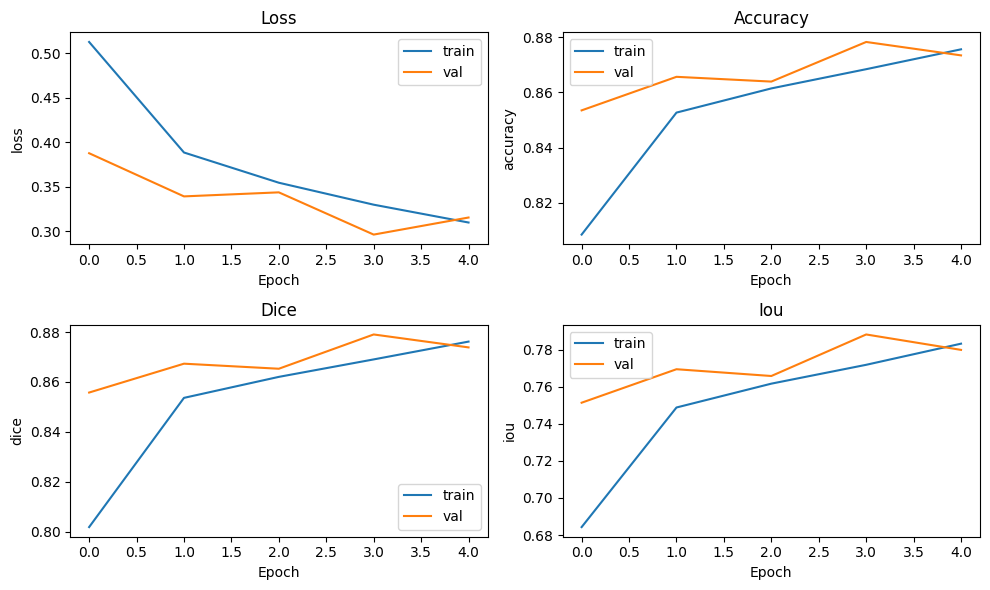

In [9]:
# Plot metrics
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.ravel()
for i, metric in enumerate(['loss', 'accuracy', 'dice', 'iou']):
    ax[i].plot(hist[f'train_{metric}'], label=f'train')
    ax[i].plot(hist[f'val_{metric}'], label=f'val')
    ax[i].set_title(metric[0].upper() + metric[1:])
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel(metric)
    ax[i].legend()
plt.tight_layout()
plt.show()

In [12]:
def evaluate(model, criterion, device, loader):
    model.eval()
    length = len(loader)
    loop = tqdm(loader, total=length, leave=True)
    loop.set_description(f'Evaluating')
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(loop):
            images = images.to(device=device)
            masks = masks.to(device=device)

            # forward
            outputs = model(images)
            loss = criterion(outputs, masks.long())

            # metrics
            preds = torch.argmax(outputs, dim=1)
            epoch_metrics = get_performance_metrics(masks.cpu(), preds.cpu())
            for k, v in epoch_metrics.items():
                loop.set_postfix({k: v})
            loop.set_postfix(loss=loss.item())

    return epoch_metrics

In [13]:
results = evaluate(model, criterion, DEVICE, test_loader)
results

Evaluating: 100%|██████████| 25/25 [00:02<00:00,  8.84it/s, loss=0.405]       


{'accuracy': 0.82879638671875,
 'precision': 0.8345374288480194,
 'sensitivity': 0.834388792115035,
 'specificity': 0.9099644,
 'dice': 0.8323900901738139,
 'iou': 0.7135687550887614}

In [ ]:
# TODO:
# - Add WandB logging
# - Add model checkpoints
# - Add early stopping